# Modular CerberusTS Experimentation

First we make sure we are in the base working directory (this is probably not necessary if using the package):

Google Colab notebooks come with most of the packages we need, but we need to upgrade pandas and install accelerate.

Then we import the necessary CerberusTS modules.

In [1]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import Foresight, train_foresight
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator

import pandas as pd

c:\Users\johnm\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we have the ability to do some custom configuration:

In [2]:
from cerberus_ts import CerberusConfig
CerberusConfig.set_masked_norm_zero = True

## Dataset Loading

Next we need a Pandas Dataframe of some wide-formatted mutlivariate timeseries data. Here we will use the Jena Climate Data found here: https://www.kaggle.com/datasets/mnassrib/jena-climate

In [3]:
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:5000,:]

## User Argument Specification
There are a number of different arguments that can be provided to Cerberus, shown below:

In [4]:
# What ratio of data needs to be available for the various call, response, and context windows to use that timestamp?
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

# How big should the call, context(s), and response windows be?
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

# What timestep should each head use?
window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

# Which columns should be used for each head?
feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)
}

## Prepare Dataset

We will use CerberusTS's TimeseriesDataPreparer class to create Torch dataloaders for all our different heads, scaled, downsampled, and coil-normalized for easy Cerberus use.

In [5]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 100)

# Prepare the data
preparer.prepare_data()

## Foresight Training

First, we can optionally train Foresight to aid CerberusTS:

In [6]:
foresight = Foresight(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [128, 128],
                 dropout_rate = 0.0,
                 eventualities = 10,
                 expander_sizes = [128, 256],
                 out_channels = 128, 
                 kernel_size = 3)

In [7]:
foresight = train_foresight(foresight, preparer.dataloaders, num_epochs = 3)

Epoch [1/3], Loss: 0.013863716904694835
Epoch [2/3], Loss: 0.010071334146584074
Epoch [3/3], Loss: 0.008806592092538873


## CerberusTS Training (No Foresight)

In [8]:
cerberus_noforesight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [128, 128, 128],
                 dropout_rate = 0.0,
                 out_channels = 128, 
                 kernel_size = 3)
                 

In [9]:
cerberus_noforesight = train_cerberus(cerberus_noforesight, preparer.dataloaders, num_epochs = 6)

Epoch [1/6], Loss: 0.001447187999341016
Epoch [2/6], Loss: 0.001022760835282194
Epoch [3/6], Loss: 0.0009319151734234765
Epoch [4/6], Loss: 0.0008887078483045722
Epoch [5/6], Loss: 0.0008646110258996487
Epoch [6/6], Loss: 0.0008424500641801084


## CerberusTS Training (With Foresight)
With the Foresight model trained (and weights frozen), we can pass this into a Cerberus model and train the remaining weights to generate predictions.

In [10]:
cerberus_foresight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [128, 128, 128],
                 dropout_rate = 0.0,
                 foresight=foresight,
                 eventualities=10,
                 out_channels = 128, 
                 kernel_size = 3)

In [11]:
cerberus_foresight = train_cerberus(cerberus_noforesight, preparer.dataloaders, num_epochs = 6)

Epoch [1/6], Loss: 0.0008644738768149788
Epoch [2/6], Loss: 0.0008162016456481069
Epoch [3/6], Loss: 0.0007914572046138346
Epoch [4/6], Loss: 0.0007727509651643535
Epoch [5/6], Loss: 0.0007520534369784097
Epoch [6/6], Loss: 0.0007330753638719519


## Results Review

CerberusTS has some built in functionality for generating responses as well as visualizing the results.

### Normalized Response Review

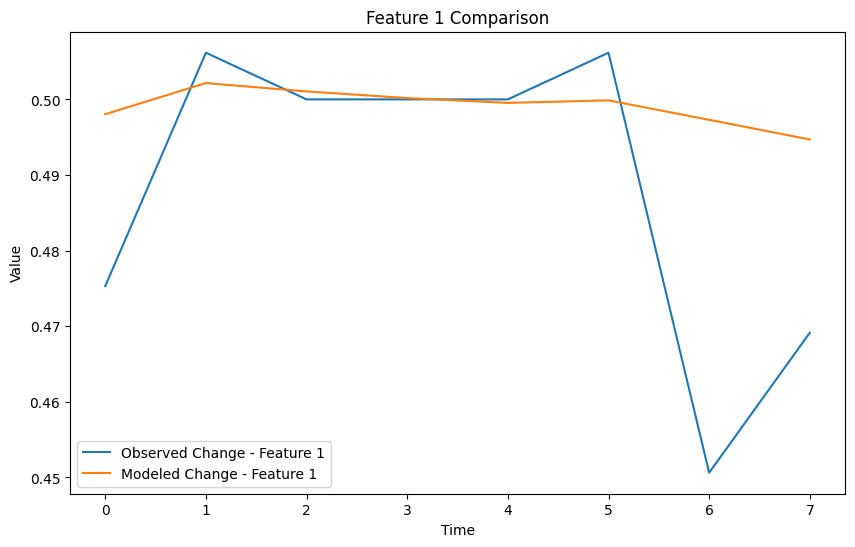

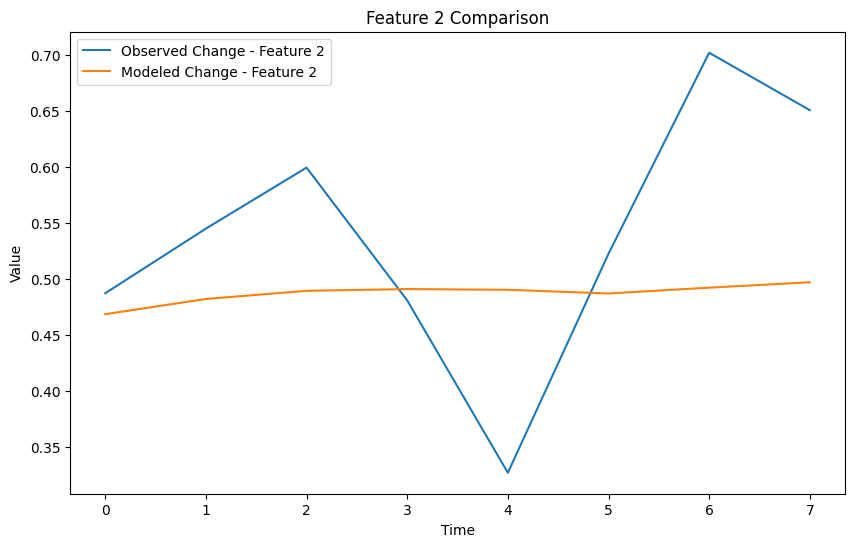

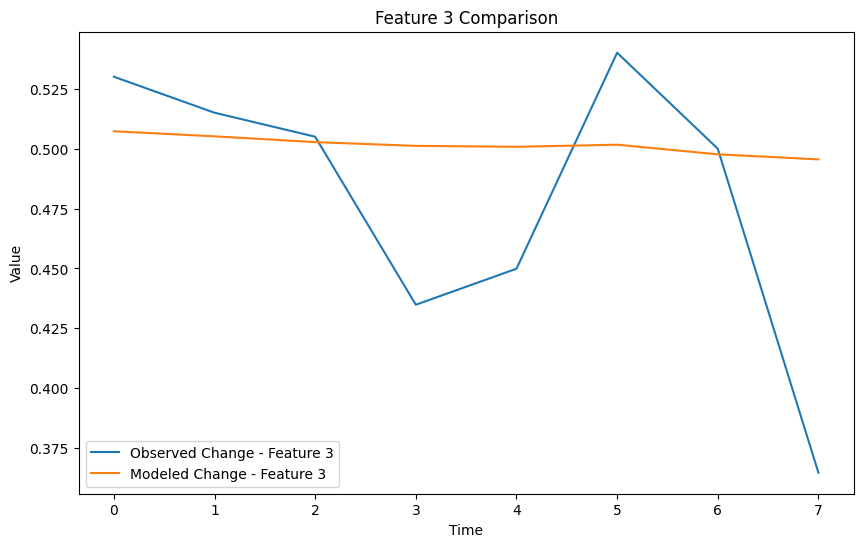

In [12]:
# Intialize Response Generator
generator = ResponseGenerator(cerberus_foresight, preparer.sliced_data, feature_indexes, preparer.max_change_dfs)

# Generate a response for a specific index
sel_index = 123
generator.generate_response(sel_index)

generator.plot_normalized_responses()

### Unscaled Response Review

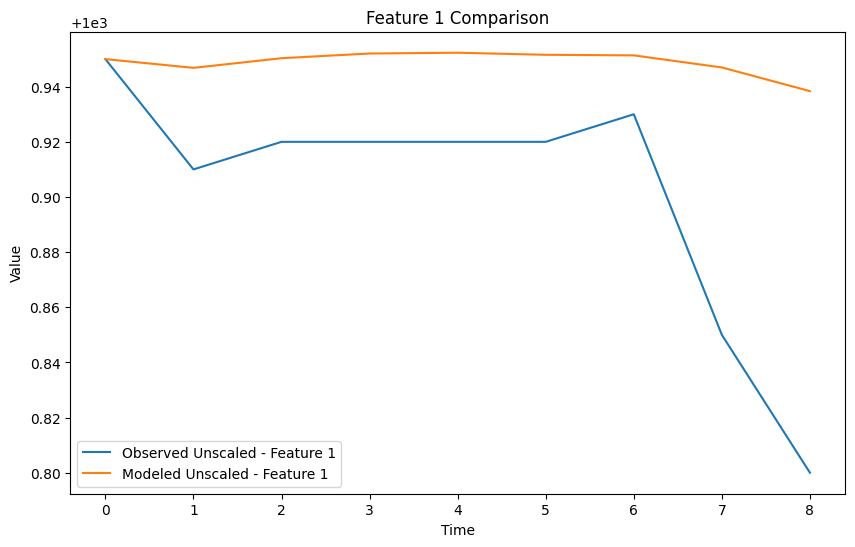

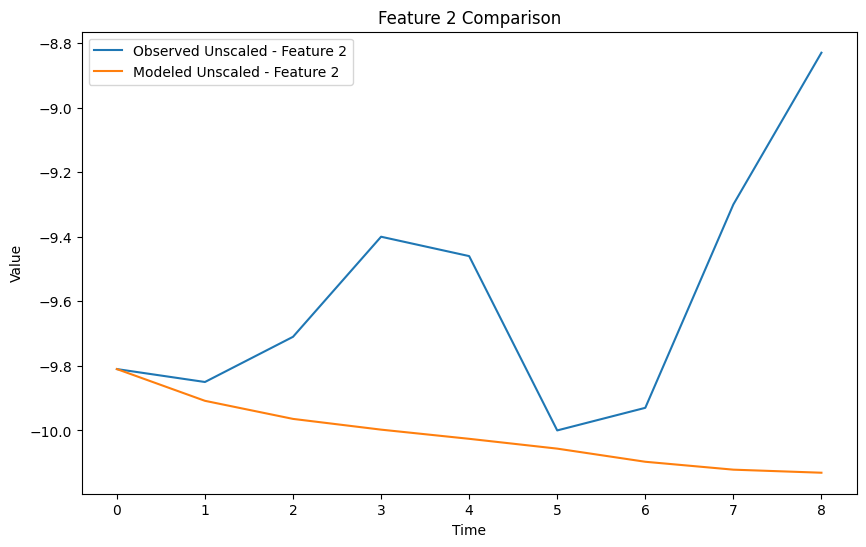

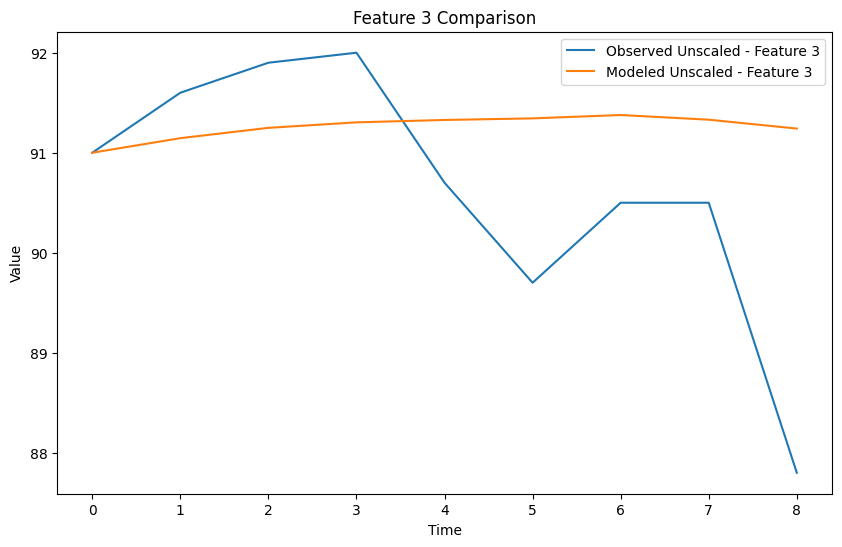

In [13]:
generator.plot_unscaled_responses(preparer.min_max_df, feature_indexes)